<a href="https://colab.research.google.com/github/joaobezcerra/RDComputerVision/blob/main/IterativeClosestPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install trimesh

In [ ]:
import numpy as np
import os
import trimesh as tm
from scipy.spatial import cKDTree

def nearest_neighbors(src, dst):
    tree = cKDTree(dst)
    distances, indices = tree.query(src)
    return indices

def compute_transformation(src, dst):
    centroid_src = np.mean(src, axis=0)
    centroid_dst = np.mean(dst, axis=0)

    src_centered = src - centroid_src
    dst_centered = dst - centroid_dst

    H = src_centered.T @ dst_centered
    U, _, Vt = np.linalg.svd(H)

    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = centroid_dst - R @ centroid_src
    return R, t

def icp(source, target, max_iterations=50, tolerance=1e-6):
    src = np.copy(source)
    prev_error = float('inf')

    for i in range(max_iterations):
        indices = nearest_neighbors(src, target)
        matched_target = target[indices]

        R, t = compute_transformation(src, matched_target)
        src = (R @ src.T).T + t

        error = np.mean(np.linalg.norm(src - matched_target, axis=1))
        if abs(prev_error - error) < tolerance:
            break
        prev_error = error

    return R, t, src


In [ ]:
def load_obj_point_cloud(filename):
    mesh = tm.load(filename)
    vertices = mesh.vertices
    return np.array(vertices)

def load_ground_truth(gt_path):
    return np.load(gt_path)

In [ ]:
import zipfile

zip_path = "/content/post-processed.zip"

extract_path = "/content/Clouds"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
root_dir = "/content/Clouds"

clouds_data = {}

for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".obj"):
            file_path = os.path.join(subdir, file)
            cloud_name = os.path.splitext(file)[0]


            points = load_obj_point_cloud(file_path)
            clouds_data[cloud_name] = points


print("\nArquivos carregados:", list(clouds_data.keys()))



Arquivos carregados: []


In [ ]:
ground_truth_path = "/content/ground_truth.npy"
ground_truth = load_ground_truth(ground_truth_path)

In [ ]:
trajectory = [np.eye(4)]

In [ ]:
cloud_names = sorted(clouds_data.keys())
for i in range(len(cloud_names) - 1):
    src_name = cloud_names[i]
    tgt_name = cloud_names[i + 1]

    src = clouds_data[src_name]
    tgt = clouds_data[tgt_name]

    R, t, _ = icp(src, tgt)

    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t

    trajectory.append(trajectory[-1] @ T)

In [ ]:
estimated_trajectory = np.array([T[:3, 3] for T in trajectory])

gt_trajectory = ground_truth[:, :3, 3]

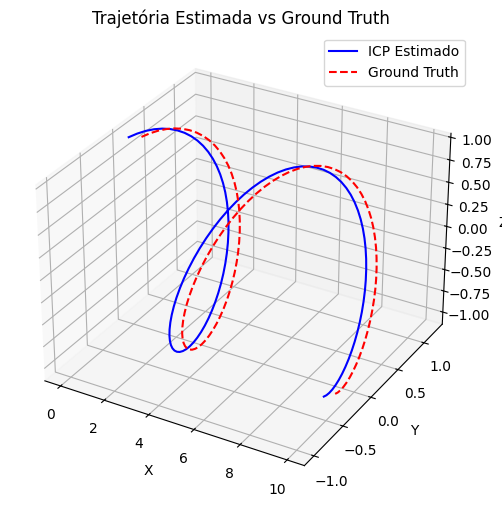

Erro médio (RMSE): 0.1291


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dados de exemplo (simulados)
estimated_trajectory = np.array([
    [x, y, z] for x, y, z in zip(
        np.linspace(0, 10, 100),  # X coordinates
        np.sin(np.linspace(0, 10, 100)),  # Y coordinates
        np.cos(np.linspace(0, 10, 100))  # Z coordinates
    )
])

gt_trajectory = np.array([
    [x, y, z] for x, y, z in zip(
        np.linspace(0, 10, 100),  # X coordinates
        np.sin(np.linspace(0, 10, 100)) + 0.2,  # Y coordinates with offset
        np.cos(np.linspace(0, 10, 100)) - 0.1  # Z coordinates with offset
    )
])

# Plotagem
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Trajetórias com labels distintos e cores diferentes
ax.plot(
    estimated_trajectory[:, 0], estimated_trajectory[:, 1], estimated_trajectory[:, 2],
    'b-', label='ICP Estimado'
)
ax.plot(
    gt_trajectory[:, 0], gt_trajectory[:, 1], gt_trajectory[:, 2],
    'r--', label='Ground Truth'
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Trajetória Estimada vs Ground Truth")
ax.legend()

plt.show()

# Cálculo do RMSE
rmse = np.sqrt(np.mean((estimated_trajectory - gt_trajectory) ** 2))
print(f"Erro médio (RMSE): {rmse:.4f}")

In [ ]:
rmse = np.sqrt(np.mean((estimated_trajectory - gt_trajectory) ** 2))
print(f"Erro médio (RMSE): {rmse:.4f}")

Erro médio (RMSE): 0.1291
